In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, countDistinct
from pyspark.sql.types import StructType, StructField, StringType, ArrayType
from pyspark.sql import functions as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# PySpark environment variables
os.environ["PYSPARK_PYTHON"] = "python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python3"

# Creating a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("EDA Conversion") \
    .getOrCreate()

file_path = "../scraper/scraped_data/scraped_data.json"
df = spark.read.option("multiLine", "true").json(file_path) # JSON structure is nested and spans multiple lines

df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/27 20:57:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+--------------------+--------------------+-------------+---------+--------------------+--------------------+--------------------+
|     image_extracted|              images|pdf_extracted|pdf_links|               texts|               title|                 url|
+--------------------+--------------------+-------------+---------+--------------------+--------------------+--------------------+
|shrama vasana fun...|[https://www.svf....|             |       []|contact us contac...|shrama vasana fun...|https://www.svf.g...|
|shrama vasana fun...|[https://www.svf....|             |       []|donate us service...|shrama vasana fun...|https://www.svf.g...|
|shrama vasana fun...|[https://www.svf....|             |       []|overview vision c...|shrama vasana fun...|https://www.svf.g...|
|shrama vasana fun...|[https://www.svf....|             |       []|contributions ser...|shrama vasana fun...|https://www.svf.g...|
|shrama vasana fun...|[https://www.svf....|             |       []|video gallery fa

In [4]:
df.printSchema()

root
 |-- image_extracted: string (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- pdf_extracted: string (nullable = true)
 |-- pdf_links: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- texts: string (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)



In [5]:
# row count
print(f"Total number of rows in the dataframe: {df.count()}")

Total number of rows in the dataframe: 14


In [6]:
unique_urls_count = df.select("url").distinct().count()
print(f"Number of unique urls scraped: {unique_urls_count}")

unique_titles_count = df.select("title").distinct().count()
print(f"Number of unique titles scraped: {unique_titles_count}")

unique_images_count = df.select(F.explode("images").alias("image")).distinct().count()
print(f"Number of unique images scraped: {unique_images_count}")

unique_pdfs_count = df.select(F.explode("pdf_links").alias("pdf_link")).distinct().count()
print(f"Number of unique pdfs scraped: {unique_pdfs_count}")

Number of unique urls scraped: 14
Number of unique titles scraped: 14
Number of unique images scraped: 65
Number of unique pdfs scraped: 15


In [7]:
df_with_word_counts = df.withColumn("word_count", F.size(F.split(F.col("texts"), " ")))
total_word_count = df_with_word_counts.agg(F.sum("word_count")).first()[0]

print(f"Total word count of webpage texts: {total_word_count}")

Total word count of webpage texts: 3646


In [8]:
average_word_count = df_with_word_counts.agg(F.avg("word_count")).first()[0]

print(f"Average word count per webpage: {average_word_count:.2f}")

Average word count per webpage: 260.43


In [9]:
texts = df.select("texts").rdd.flatMap(lambda x: x).collect() # list of strings

In [10]:
def plot_word_cloud(texts):
    combined_text = ' '.join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off the axis
    plt.show()

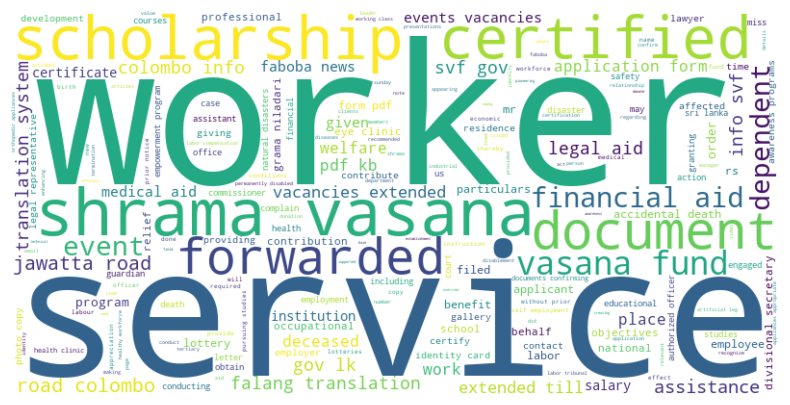

In [11]:
# Plot word cloud for all webpage texts
plot_word_cloud(texts)

In [12]:
pdf_texts = df.select("pdf_extracted").rdd.flatMap(lambda x: x).collect()
df_with_pdf_word_counts = df.withColumn("pdf_word_count", F.size(F.split(F.col("pdf_extracted"), " ")))
total_pdf_word_count = df_with_pdf_word_counts.agg(F.sum("pdf_word_count")).first()[0]
print(f"Total word count of all pdfs: {total_pdf_word_count}")
average_pdf_word_count = df_with_pdf_word_counts.agg(F.avg("pdf_word_count")).first()[0]
print(f"Average word count per pdf: {average_pdf_word_count:.2f}")


Total word count of all pdfs: 8348
Average word count per pdf: 596.29


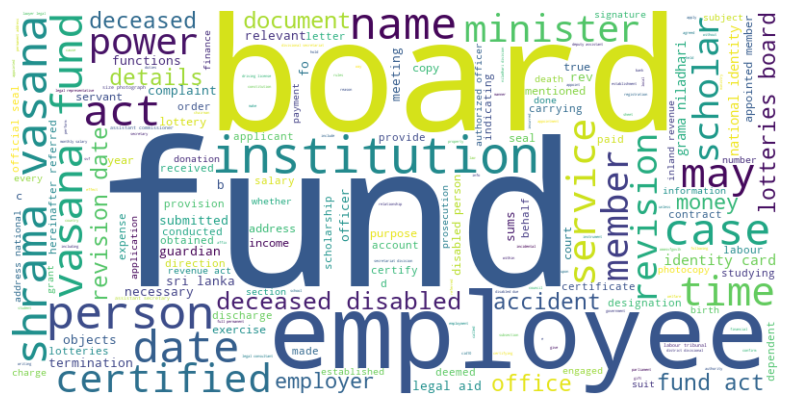

In [13]:
# Plot word cloud for pdf texts
plot_word_cloud(pdf_texts)

In [21]:
image_texts = df.select("image_extracted").rdd.flatMap(lambda x: x).collect()
df_with_image_word_counts = df.withColumn("image_word_count", F.size(F.split(F.col("image_extracted"), " ")))
total_image_word_count = df_with_image_word_counts.agg(F.sum("image_word_count")).first()[0]
print(f"Total word count of all images: {total_image_word_count}")
average_image_word_count = df_with_image_word_counts.agg(F.avg("image_word_count")).first()[0]
print(f"Average word count per image {average_image_word_count:.2f}")

Total word count of all images: 179
Average word count per image 12.79


In [15]:
def get_top_words(text_list, num_words):
  CV = CountVectorizer(stop_words='english') 
  word_count = CV.fit_transform(text_list)

  word_sum = word_count.sum(axis=0)

  frequency = []
  for word, index in CV.vocabulary_.items():
    frequency.append((word, word_sum[0, index]))

  frequency = sorted(frequency, key=lambda x: x[1], reverse=True)[:num_words]
  return frequency

In [16]:
def top_words_chart(texts, title): 
    texts = get_top_words(texts, 10)
    words = [] 
    freqs = []
    for text, freq in texts: 
        words.append(text)
        freqs.append(freq)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=freqs, y=words)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(title)
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_core.py:1478: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


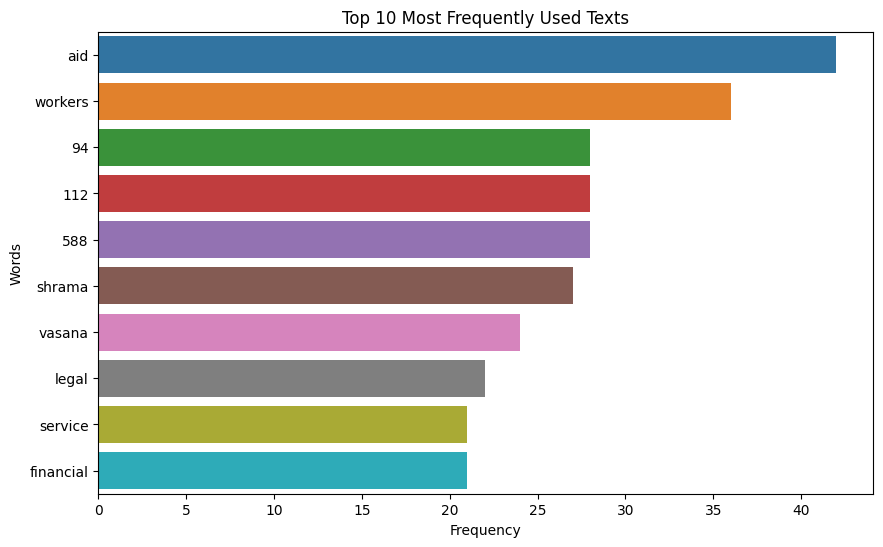

In [17]:
# Top 10 most frequently used texts
top_words_chart(texts, 'Top 10 Most Frequently Used Texts')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_core.py:1478: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


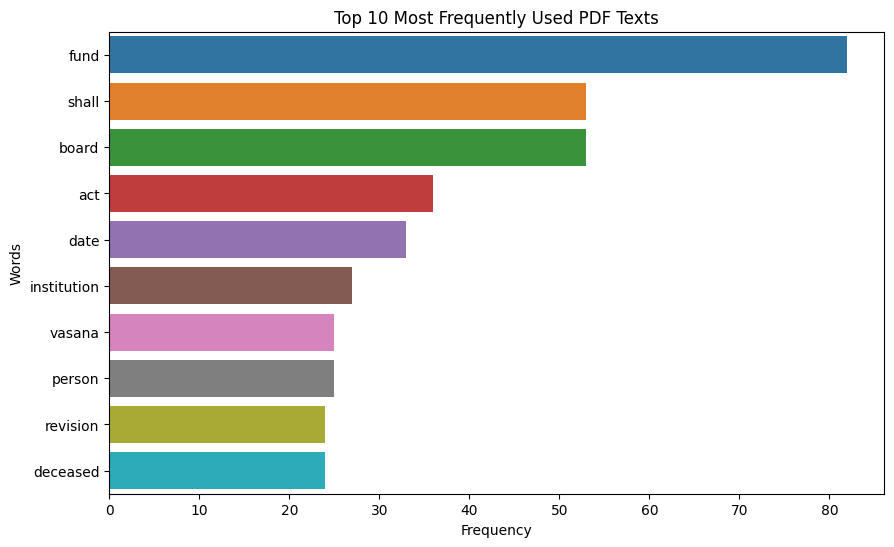

In [18]:
# Top 10 most frequently used pdf texts
top_words_chart(pdf_texts, 'Top 10 Most Frequently Used PDF Texts')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_core.py:1478: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


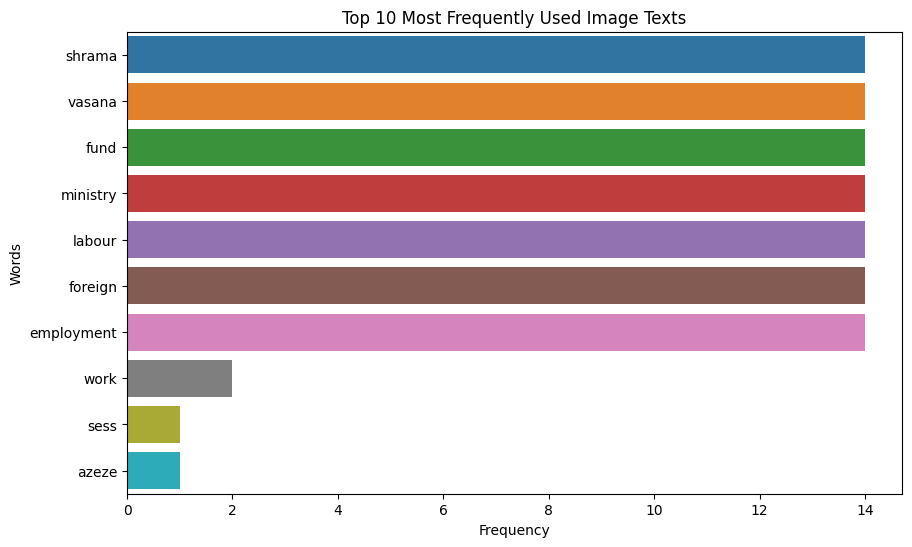

In [22]:
# Top 10 most frequently used image texts
top_words_chart(image_texts, 'Top 10 Most Frequently Used Image Texts')

In [23]:
# Bi-grams: Identify common word pairs
def n_grams(text_list, n): 
    n_grams = []
    CV = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngrams = CV.fit_transform(texts)
    ngram_list = CV.get_feature_names_out()
    ngram_frequencies = ngrams.toarray().sum(axis=0)
    ngram_freq = sorted(list(zip(ngram_list, ngram_frequencies)), key=lambda x: x[1], reverse=True)
    for ngram, freq in ngram_freq[:10]:
        n_grams.append((ngram, freq))
    return n_grams

In [24]:
def n_grams_chart(text_list, n, title):
    texts = n_grams(text_list, n)
    words = [] 
    freqs = []
    for text, freq in texts: 
        words.append(text)
        freqs.append(freq)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=freqs, y=words)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(title)
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_core.py:1478: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


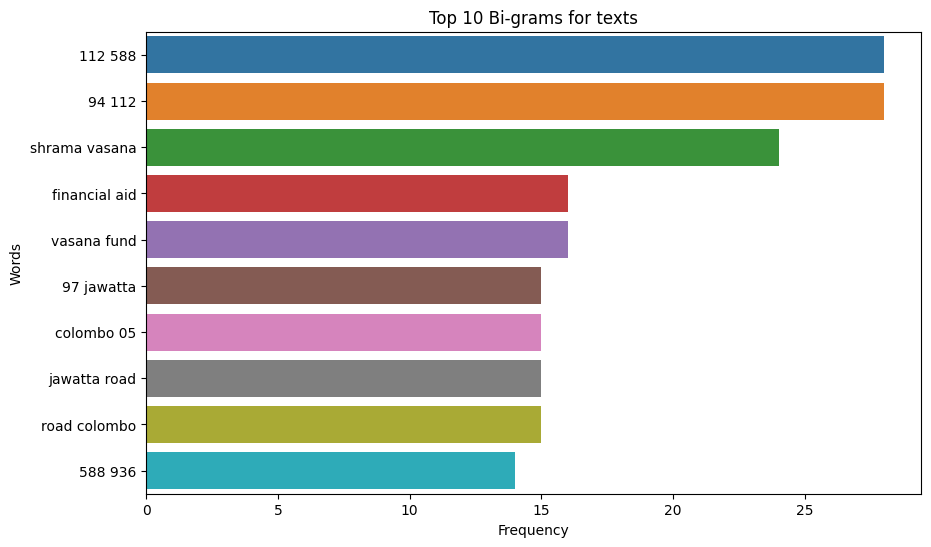

In [25]:
# Top 10 Frequently Used Word Pairs For Texts
n_grams_chart(texts, 2, "Top 10 Bi-grams for texts")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_core.py:1478: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


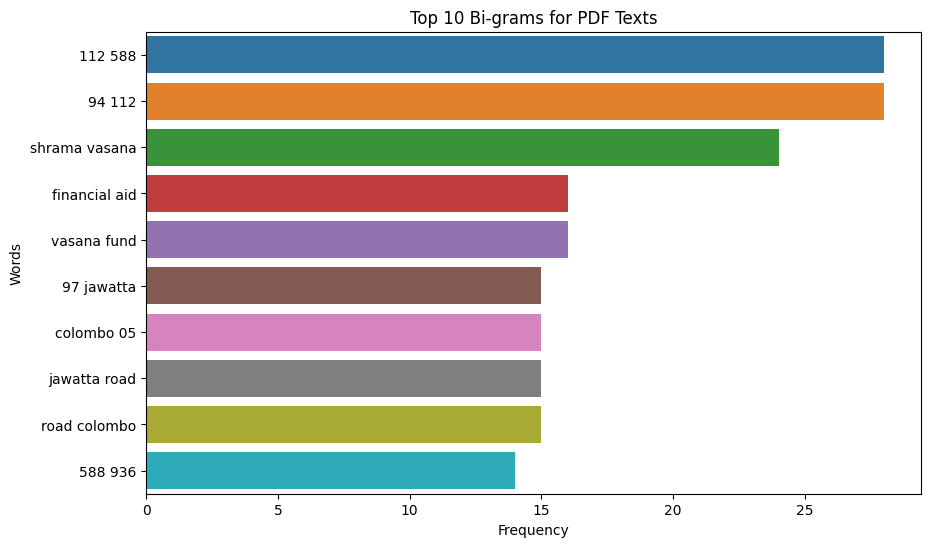

In [26]:
# Top 10 Frequently Used Word Pairs For PDF Texts
n_grams_chart(pdf_texts, 2, "Top 10 Bi-grams for PDF Texts")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_core.py:1478: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


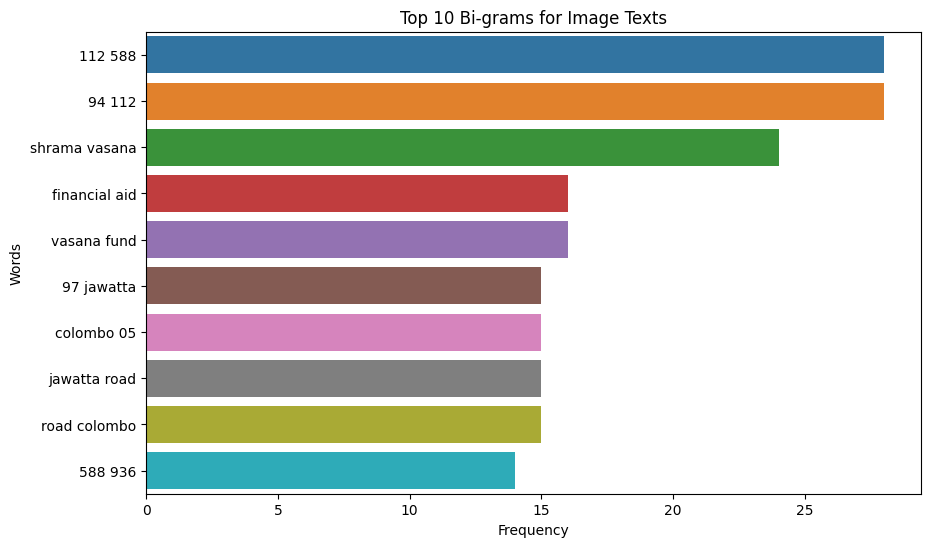

In [27]:
# Top 10 Frequently Used Word Pairs For Image Texts
n_grams_chart(image_texts, 2, "Top 10 Bi-grams for Image Texts")